[Глава 1](#1) \
[Глава 2](#2)\
[Глава 3 Обучение](#3)\
[Глава 4 Анализ](#4)

<a id=1></a>
 # Определение возраста покупателей

Необходимо создать нейросеть на основе ResNet50, используя уже заданные веса. Сеть должна предсказывать возраст по фото, это задача регрессии.

<a id=2></a>
## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=500,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
features = next(gen_flow)

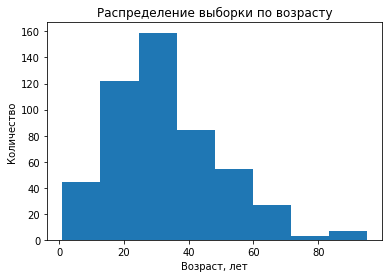

In [4]:
plt.hist(features[1], bins=8)
plt.title('Распределение выборки по возрасту')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

Распределение похоже на Пуассона, и выглядит относительно реалистично. Подозрителен резкий пик после 80 лет после провала около 70 лет. Либо данные собирались предвзято, либо с ними что-то еще не то \
Потенциально это может повлияет на показатели качества обученной нейронки.


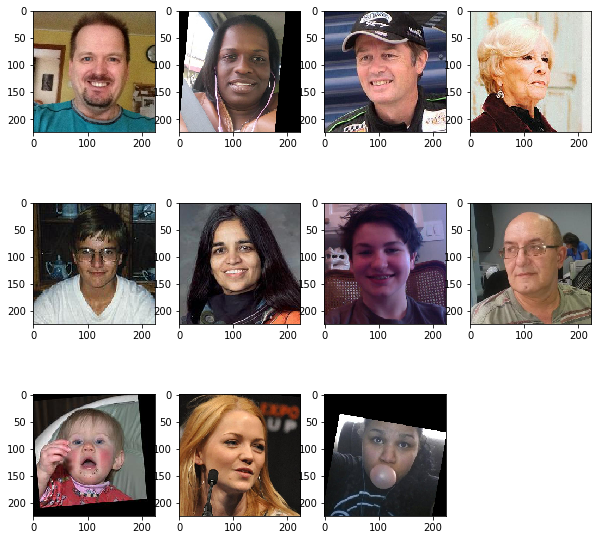

In [5]:
plt.figure(figsize=(10,10))
for i in range(0,11):
    plt.subplot(3, 4, i+1)
    plt.imshow(features[0][i], interpolation='nearest')
plt.show()

**Вывод** В выборке 7,6т объектов, по которым нейроннаяеть должна научиться определять возраст. Считается, что для сверточных нейронных сетей необходимо минимум 5т изображений. Для задач классификации – по 1т на каждый класс, но определние возраста – задача регрессии. Скорее всего, нейронная сеть обучится с удовлетворительной точностью.\
В распределении возраста наблюдается странность – фото  возрастом более 80 лет находится в подозрительно большом количестве.\
Фото сделаны с разных ракурсов, присутствуют посторонние объекты, освещение тоже сильно варьируется. Также нельзя опустить тот фактор, что в выборке люди разных рас, и для каждой возраст проявляется по-разному. В целом задача определения возраста даже для людей сложная, и определить его с точностью до года невозможно. С учетом упомянутых выше факторов, предположу, что в целом сеть сможет отличить детей и стариков, а в остальном будет заметно ошибаться

<a id=3></a>
## Обучение модели

Код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.applications.resnet import ResNet50
# from tensorflow.keras.layers import AvgPool2D, Dense, Flatten
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# import numpy as np
# import pandas as pd
# from tensorflow.keras.losses import MeanAbsoluteError
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import AvgPool2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.losses import MeanAbsoluteError


optimizer = Adam(lr=0.0001)

SEED = 12345


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255,
                                       horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224,224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=SEED)
    return train_datagen_flow 

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                         directory=path+'final_files/',
                                                         x_col='file_name',
                                                         y_col='real_age',
                                                         target_size=(224,224),
                                                         batch_size=32,
                                                         class_mode='raw',
                                                         subset='validation',
                                                         seed=SEED)
    return test_datagen_flow 

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(AvgPool2D())
    model.add(Flatten())
    model.add(Dense(units=3, activation ='relu'))
    model.add(Dense(units=1, activation ='relu'))
    model.compile(optimizer=optimizer, loss=MeanAbsoluteError(), metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

Результат со слоем Flatten оказался лучшим:

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
178/178 - 66s - loss: 9.8241 - mae: 9.8248 - val_loss: 20.2397 - val_mae: 20.2312
Epoch 2/5
178/178 - 38s - loss: 6.8068 - mae: 6.8070 - val_loss: 19.0470 - val_mae: 19.0317
Epoch 3/5
178/178 - 38s - loss: 5.8757 - mae: 5.8761 - val_loss: 18.1984 - val_mae: 18.1829
Epoch 4/5
178/178 - 38s - loss: 5.1145 - mae: 5.1148 - val_loss: 8.7995 - val_mae: 8.8039
Epoch 5/5
178/178 - 37s - loss: 4.7259 - mae: 4.7257 - val_loss: 6.9870 - val_mae: 6.9999
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 6.9870 - mae: 6.9999
Test MAE: 6.9999

```

In [11]:
import tensorflow as tf

# просто создаем тензор.
x = tf.cast( tf.random.uniform(shape=(32, 64, 64, 3), minval=0, maxval=256, dtype=tf.int32), tf.float32)

flatten = tf.keras.layers.Flatten()
pool1 = tf.keras.layers.AvgPool2D()
pool = tf.keras.layers.GlobalAveragePooling2D()


conv = tf.keras.layers.Conv2D(64, 3)

print('Размерность после свертки:', conv(x).shape)

print('\nАvgPool2D:', pool1(conv(x)).shape)
print('GlobalAveragePooling2D:', pool(conv(x)).shape)

print('\nFlatten after АvgPool2D:', flatten(pool1(conv(x))).shape)
print('Flatten after GlobalAveragePooling2D:', flatten(pool(conv(x))).shape)

Размерность после свертки: (32, 62, 62, 64)

АvgPool2D: (32, 31, 31, 64)
GlobalAveragePooling2D: (32, 64)

Flatten after АvgPool2D: (32, 61504)
Flatten after GlobalAveragePooling2D: (32, 64)


<a id=4></a>
## Анализ обученной модели

Самой лучшей моделью оказалась стандартная ResNet50 с парой слоев и одним нейроном на выходе для значения возраста. Функция активации Relu также значительно улучшила итоговый результат

**Возможные альтернативы**

- Помимо использовавшейся MAE возможно применение MSE и Huber loss. MSE чувствительнее к выбросам, поэтому лучше применять ее там, где они редкие и большие. Для данных в проекте это было не характерно, поэтому использовалась MAE. Но при этом MSE вычисляется быстрее. Помимо этих функций применяется Huber loss, которая имеет преимущества как MAE, так и MSE. Она более устойчива к выбросам, чем MSE, но может обнаружить маленькие ошибки, которые пропустит MAE.
- Дополнительное улучшение качества модели. Возможно применение библиотек аугментации данных, например albumentations, борьба с переобучением (например, dropout). 
- Оптимизатор и шаг грандиента. Вместо Adam используют SGD и AdamW, а LearningRateScheduler меняет шаг в зависимости от стадии обучения. Последнее больше актуально для проектов с большим количеством эпох.